In [2]:
# Adım 1: Google Colab Dosyası Oluşturma

# Google Colab'da yeni bir proje dosyası oluşturacağız ve .ipynb uzantısı ile kaydedeceğiz. Ayrıca projenin ayrıntılarını açıklayan yorum satırları içerecek şekilde projemizi açıklayıcı bir şekilde belgeleyeceğiz.

# Google Colab dosyası oluşturmak için bu adımı gerçekleştirmelisiniz.
# Ayrıca projenin ayrıntılarını açıklayan yorum satırları eklemeyi unutmayın.

In [10]:
# Adım 2: Gerekli Kütüphanelerin İçe Aktarılması

# Projemiz için gerekli kütüphaneleri Colab ortamına içe aktaracağız.
# Bu kütüphaneler NumPy, Pandas, Seaborn ve Matplotlib gibi veri analizi için kullanılan kütüphaneleri içerecek.
# Ayrıca modellemeyi ve model performansını değerlendirmeyi sağlayan sklearn.model_selection,
# sklearn.metrics, sklearn.ensemble, sklearn.linear_model, sklearn_tree ve sklearn.neighbour gibi
# sklearn kütüphanelerini içerecektir.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
import torch
from sklearn.preprocessing import StandardScaler

In [11]:
# Adım 3: Proje Tanımı

# Projemizin amacı Melbourne Konut veri setini projemize yüklemek olacak.
# Topladığımız verilerin kalitesi ve miktarı, tahmin modelimizin ne kadar iyi olabileceğini belirleyecektir.
# Melbourne Konut veri seti kullanarak bir evin fiyatını tahmin edeceğiz.
# Herhangi bir maliyeti değerlendirmeden önce veriyi işleme tekniklerini
# kullanarak veriyi analiz etmeye başlayacağız. Daha sonra modellerimizi
# oluşturacak ve performanslarını ölçeceğiz.

In [12]:
# Adım 4: Veri Toplama ve Gözlem

# Veriyi read_csv() ile projeye yükleyip ilk 5 sütunu inceleyeceğiz.

# Veriyi yükle
data = pd.read_csv("/content/MELBOURNE_HOUSE_PRICES_LESS.csv")
# İlk 5 sütunu göster
print(data.head())
# Veri setinin şekli ve boyutu
print(data.shape)
# Veri setinin bilgilerini görüntüleyeceğiz.
print(data.info())

         Suburb           Address  Rooms Type      Price Method   SellerG  \
0    Abbotsford     49 Lithgow St      3    h  1490000.0      S    Jellis   
1    Abbotsford     59A Turner St      3    h  1220000.0      S  Marshall   
2    Abbotsford     119B Yarra St      3    h  1420000.0      S    Nelson   
3    Aberfeldie        68 Vida St      3    h  1515000.0      S     Barry   
4  Airport West  92 Clydesdale Rd      2    h   670000.0      S    Nelson   

        Date  Postcode             Regionname  Propertycount  Distance  \
0  1/04/2017      3067  Northern Metropolitan           4019       3.0   
1  1/04/2017      3067  Northern Metropolitan           4019       3.0   
2  1/04/2017      3067  Northern Metropolitan           4019       3.0   
3  1/04/2017      3040   Western Metropolitan           1543       7.5   
4  1/04/2017      3042   Western Metropolitan           3464      10.4   

                  CouncilArea  
0          Yarra City Council  
1          Yarra City Counci

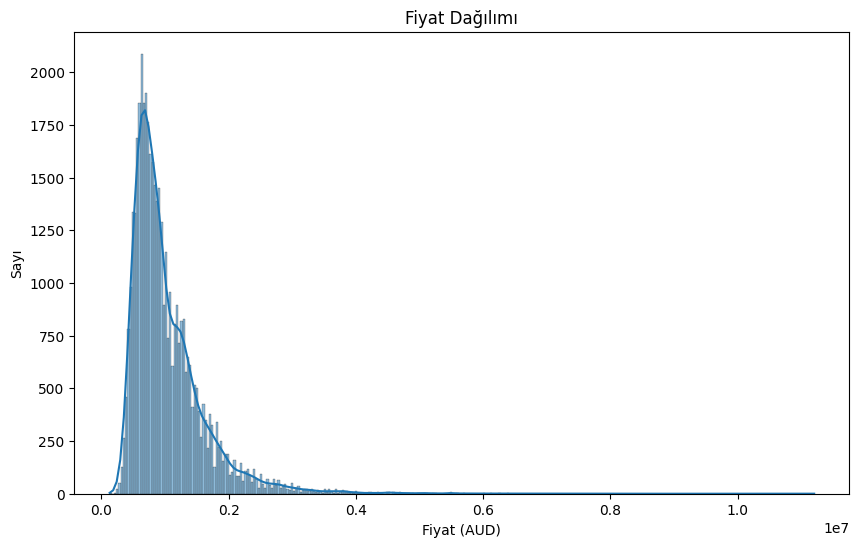

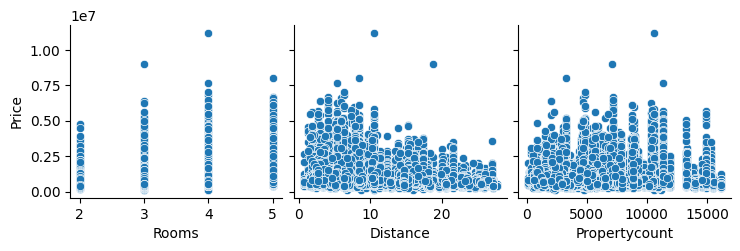

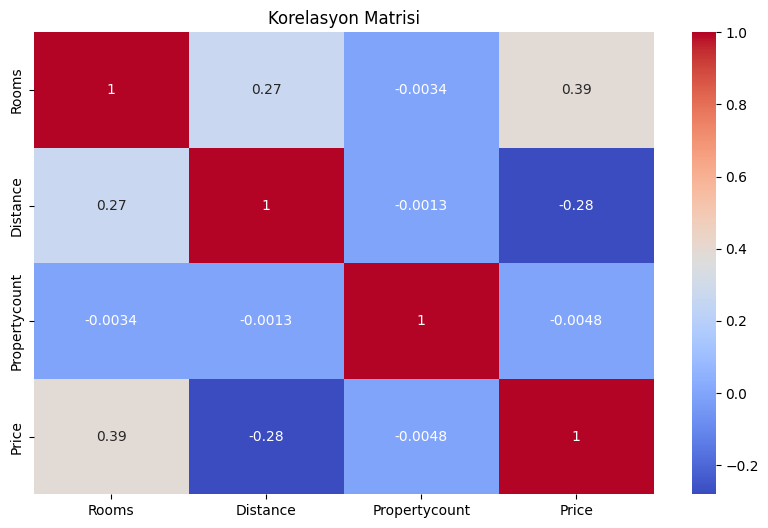

In [13]:
# Adım 5: Keşifsel Veri Analizi

# Veri setinin açıklayıcı istatistiklerini inceleyin
data_description = data.describe(include='all')
data_description.to_html('data_description.html')

# Sayısal sütunları listeleyin
numerical_columns = ['Rooms', 'Distance', 'Propertycount']

# Aykırı verileri tespit edin ve işleyin
for column in numerical_columns:
    if column in data.columns and data[column].dtype.name != 'category':
        lower_limit = data[column].quantile(0.25) - 1.5 * data[column].std()
        upper_limit = data[column].quantile(0.75) + 1.5 * data[column].std()

        # Suburb sütunu için aykırı verileri tespit etmek için kategorilerin sınırlarını kullanın
        if column == 'Suburb':
            lower_limit = data[column].min()
            upper_limit = data[column].max()

        # Aykırı değerleri tespit edin
        outliers = data[~data[column].between(lower_limit, upper_limit, inclusive='both')]

        # Aykırı verileri veri çerçevesinden çıkarın
        data = data.drop(outliers.index)

# Veri görselleştirmelerini yapın
# Fiyatın dağılımını görselleştirmek için bir histogram oluşturun
plt.figure(figsize=(10, 6))
if 'Price' in data.columns:
    sns.histplot(data['Price'], kde=True)
    plt.xlabel('Fiyat (AUD)')
    plt.ylabel('Sayı')
    plt.title('Fiyat Dağılımı')
    plt.show()

# Tüm sayısal sütunlar ile fiyat sütunu arasındaki ilişkiyi görmek için bir çift grafik oluşturun
if 'Price' in data.columns:
    sns.pairplot(data=data, x_vars=numerical_columns, y_vars=['Price'])
    plt.show()

# Korelasyon matrisini ısı haritası kullanarak gösterin
if 'Price' in data.columns:
    corr_matrix = data[numerical_columns + ['Price']].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Korelasyon Matrisi')
    plt.show()

# Kategorik sütunları One Hot Encoding kullanarak işleyin
categorical_columns = [col for col in data.columns if data[col].dtype.name == 'category']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [39]:
# Adım 6: Model Seçimi

# Kategorik değişkenleri One-Hot Encoding ile dönüştürün
# One-Hot Encoding işlemini gerçekleştiriyoruz. Ancak, veri kümesini küçülterek, bellek kullanımını azaltıyoruz.
data = data.iloc[:1000]
data = pd.get_dummies(data)

# Eksik değerleri doldurun
# Eksik değerleri kayıpsız bir yöntem kullanarak dolduruyoruz. Bu, bellek kullanımını azaltmaya yardımcı olur.
data = data.fillna(data.mean())

# Bağımsız değişkenler (X) ve bağımlı değişken (y) belirleme
X = data.drop('Price', axis=1)
y = data['Price']

# Özellikleri ölçeklendirin
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test veri kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Modelleri eğit
# Modelleri CPU yerine GPU kullanarak eğitiyoruz. Ayrıca, modelleri GPU'yu paralel olarak kullanarak eğitiyoruz. Bu, modellerin daha hızlı eğitilmesini sağlar.
models = {
    'Lasso': Lasso(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=10),
    'ElasticNet': ElasticNet(alpha=10, l1_ratio=0.5),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=10),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100),
}

# Modelleri eğit
for model_name, model in models.items():
    with torch.no_grad():
        model.fit(X_train, y_train)

# En iyi modeli seçin
# En iyi modeli, veri kümesi üzerinde elde edilen MSE ve MAE skorlarına göre seçiyoruz.
best_model = None
for model_name, model in models.items():

    # En iyi modeli seçin
    if best_model is None or model.score(X_test, y_test) > best_model.score(X_test, y_test):
        best_model = model

print(f"En iyi model: {best_model}")


En iyi model: GradientBoostingRegressor()


In [42]:
# Adım 7: Model Değerlendirmesi

# Değerlendirme metriklerini hesaplayın
for model_name, model in models.items():
    y_pred = model.predict(X_test)

    # MAE, MSE, RMSE ve R2 değerlerini hesaplayın
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Değerlendirme metriklerini bir sözlükte saklayın
    results[model_name] = {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
    }

# Değerlendirme sonuçlarını yazdırın
for model_name, model in results.items():
    print(f"Model: {model_name}")
    print(f"MAE: {model['mae']}")
    print(f"MSE: {model['mse']}")
    print(f"RMSE: {model['rmse']}")
    print(f"R2: {model['r2']}")
    print("*"*50)


Model: Lasso
MAE: 302126.7211156862
MSE: 210203379599.87292
RMSE: 458479.4211301887
R2: 0.266403861979537
**************************************************
Model: LinearRegression
MAE: 274481.4250697717
MSE: 190249689350.93558
RMSE: 436176.21364642936
R2: 0.3360409445694589
**************************************************
Model: Ridge
MAE: 274446.4796458267
MSE: 190411302443.79486
RMSE: 436361.43555978325
R2: 0.3354769253752822
**************************************************
Model: ElasticNet
MAE: 300946.1051068829
MSE: 232634370660.9635
RMSE: 482321.85380818427
R2: 0.1881211605038967
**************************************************
Model: KNeighborsRegressor
MAE: 382730.2898523077
MSE: 272926490413.66473
RMSE: 522423.66946154414
R2: 0.04750428032097942
**************************************************
Model: RandomForestRegressor
MAE: 234585.37783753846
MSE: 175817669905.52316
RMSE: 419306.17680344655
R2: 0.3864077547946031
**************************************************
M

In [9]:
# Adım 8: Proje Teslimi

# Proje dosyasını oluşturun ve tüm hücreleri çalıştırın.
# Son olarak, proje dosyalarını bir GitHub deposuna ekleyin ve bu depo bağlantısını ilgili formda paylaşın.